In [72]:
#importing all the libraries 
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine Learning libraries  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

# Machine Learning Part of B2B Order Management Application 


Through this model we have tried to predict the date of payment and aging bucket of an invoice from the invoice creation. The whole purpose of the model is to help the account receivel team in the payment processs from the past Experiences 
<br>
<br>
Similar to any machine learning project it is a kind of supervised probelm and we have applied regression for the purpose
<br>
Here is the Workflow of the Whole Process.
<br> 
1. Dataset
2. Preprocessing 
3. EDA and Data Visualization
4. Feature Selection
5. Machine Learning Algorithms 
6. Hyperparameters tunning 
7. Model Selection
8. Bucketing 

![title](flow.png)

# Dataset 

### <b> Observation</b>

* There is a Duplicate available in dataset named 'document_create_date.1' 
* There is also rows available in the dataset that is missing large number of value i.e clear_date,area_business so we dropped these rows
* Two more thing thing that is noticeable  is <b> date and Currency </b> is not in well formeted 

In [73]:
def load_data(notebook_name):
    " should be working in the same path "
    import os
    path= os.getcwd()
    print("currently working in "+ str(os.listdir()))
    path= os.getcwd()
    data = pd.read_csv(os.getcwd()+"//"+notebook_name)
    df = pd.DataFrame(data)
    return data


In [74]:
df = load_data("data.csv") 

df.columns

currently working in ['.ipynb_checkpoints', 'data.csv', 'experiment.csv', 'flow.png', 'ml_copy.ipynb', 'Modeling_assignment.ipynb', 'rough.ipynb']


Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'document type', 'posting_id', 'area_business', 'total_open_amount',
       'baseline_create_date', 'cust_payment_terms', 'invoice_id', 'isOpen'],
      dtype='object')

In [75]:
df.shape

(50000, 19)

In [76]:
## Duplicates
df_drop = df.drop(['document_create_date.1'], axis=1)

# finding nan values 
df_drop.isna().sum()

business_code               0
cust_number                 0
name_customer               0
clear_date              10000
buisness_year               0
doc_id                      0
posting_date                0
document_create_date        0
due_in_date                 0
invoice_currency            0
document type               0
posting_id                  0
area_business           50000
total_open_amount           0
baseline_create_date        0
cust_payment_terms          0
invoice_id                  6
isOpen                      0
dtype: int64

In [77]:
df_drop1 = df_drop.drop(['area_business'], axis = 1)

# There are 10000 rows with clear date missing which is useful in finding payment delay predictions, so these rows are useless.
df_drop2 = df_drop1.dropna(axis = 0, how ='any') # additionally removing those 10 null values too for invoice_id
df_drop2.shape
# df_drop2.isna().sum()

(39994, 17)

In [87]:
df_drop2[:10]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,20200125,20200210.0,USD,RV,1.0,54273.28,20200126.0,NAH4,1.930438e+09,0,2020-02-10,1
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,20190722,20190811.0,USD,RV,1.0,79656.60,20190722.0,NAD1,1.929646e+09,0,2019-08-11,-3
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,20190914,20190929.0,USD,RV,1.0,2253.86,20190914.0,NAA8,1.929874e+09,0,2019-09-29,92
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,20191113,20191128.0,USD,RV,1.0,33133.29,20191113.0,NAH4,1.930148e+09,0,2019-11-28,-3
5,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,20190920,20191004.0,CAD,RV,1.0,22225.84,20190924.0,CA10,2.960581e+09,0,2019-10-04,61
6,U001,0200769623,WAL-MAR in,2019-11-12,2019.0,1.930083e+09,2019-11-01,20191031,20191116.0,USD,RV,1.0,7358.49,20191101.0,NAH4,1.930083e+09,0,2019-11-16,-4
8,U001,0200769623,WAL-MAR corp,2019-06-18,2019.0,1.929440e+09,2019-06-07,20190605,20190622.0,USD,RV,1.0,15995.04,20190607.0,NAH4,1.929440e+09,0,2019-06-22,-4
9,U001,0200762301,C&S WH systems,2019-03-06,2019.0,1.928819e+09,2019-02-20,20190219,20190307.0,USD,RV,1.0,28.63,20190220.0,NAC6,1.928819e+09,0,2019-03-07,-1
11,U001,0200743129,BROOKS co,2019-01-22,2019.0,1.928551e+09,2019-01-02,20190102,20190117.0,USD,RV,1.0,103147.37,20190102.0,NAA8,1.928551e+09,0,2019-01-17,5
12,U001,0200186937,SYSC corporation,2019-05-06,2019.0,1.929152e+09,2019-04-15,20190415,20190430.0,USD,RV,1.0,16381.45,20190415.0,NAA8,1.929152e+09,0,2019-04-30,6


# remember to convert amount into usd  

In [28]:
currecy = (df["invoice_currency"])

for i in range(len(currecy)):
    if(currecy[i]=="USD"):
        c+=1
    elif(currecy[i]=="CAD"):
        d +=1 
print(c,d)      
        

NameError: name 'c' is not defined

# convert the date into proper formet 

In [32]:
def change_date(x_type):
    x = int(x_type)
    x = str(x)
    year = int(x[0:4])
    month = int(x[4:6])
    day = int(x[6:])
    return dt.datetime(year, month, day)

In [71]:
type(change_date(20200210.0))

datetime.datetime

In [80]:
df_drop2['due_date'] = df_drop2['due_in_date'].apply(change_date)
df_drop2['clear_date']= pd.to_datetime(df_drop2['clear_date']) 

# Creating target variable
df_drop2['target'] = (df_drop2['clear_date'] - df_drop2['due_date']).dt.days
# df_drop2.head(5) target value +ve means there was a delay in payment.

C:\Users\karti\AppData\Local\Temp\ipykernel_344\4228992668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop2['due_date'] = df_drop2['due_in_date'].apply(change_date)
C:\Users\karti\AppData\Local\Temp\ipykernel_344\4228992668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop2['clear_date']= pd.to_datetime(df_drop2['clear_date'])
C:\Users\karti\AppData\Local\Temp\ipykernel_344\4228992668.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [88]:
df_drop2["target"]

0         1
1        -3
2        92
4        -3
5        61
         ..
49994     0
49996     4
49997     0
49998     0
49999    -9
Name: target, Length: 39994, dtype: int64

In [35]:
df_drop2['document_create_date'] = df_drop2['document_create_date'].apply(change_date)
df_drop2['baseline_create_date'] = df_drop2['baseline_create_date'].apply(change_date)

print(pd.to_datetime(df_drop2['document_create_date']).min()) 
print(pd.to_datetime(df_drop2['document_create_date']).max())

C:\Users\karti\AppData\Local\Temp\ipykernel_344\452077917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop2['document_create_date'] = df_drop2['document_create_date'].apply(change_date)
C:\Users\karti\AppData\Local\Temp\ipykernel_344\452077917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop2['baseline_create_date'] = df_drop2['baseline_create_date'].apply(change_date)


2018-12-26 00:00:00
2020-03-02 00:00:00


In [36]:
# Splitting the initial dataframe into train and test
# So in this case we can consider last 3 months for test set.
x_train = df_drop2[df_drop2['document_create_date'] <= '2020-01-01'].copy()
x_test = df_drop2[df_drop2['document_create_date'] > '2020-01-01'].copy()


In [37]:
x_test.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-01-25,20200210.0,USD,RV,1.0,54273.28,2020-01-26,NAH4,1.930438e+09,0,2020-02-10,1
19,U001,0200769623,WAL-MAR systems,2020-02-05,2020.0,1.930438e+09,2020-01-24,2020-01-24,20200208.0,USD,RV,1.0,53349.54,2020-01-24,NAH4,1.930438e+09,0,2020-02-08,-3
20,U013,0100053554,SYSTEMS systems,2020-02-11,2020.0,1.991838e+09,2020-01-11,2020-01-07,20200210.0,USD,RV,1.0,5683.50,2020-01-11,NAVE,1.991838e+09,0,2020-02-10,1
24,U001,0200769623,WAL-MAR co,2020-02-04,2020.0,1.930431e+09,2020-01-24,2020-01-23,20200208.0,USD,RV,1.0,11307.78,2020-01-24,NAH4,1.930431e+09,0,2020-02-08,-4
41,U001,0200769623,WAL-MAR associates,2020-01-21,2020.0,1.930353e+09,2020-01-04,2020-01-04,20200119.0,USD,RV,1.0,4953.83,2020-01-04,NAH4,1.930353e+09,0,2020-01-19,2


In [27]:
print(x_train.shape)
print(x_test.shape)

(34971, 19)
(5023, 19)


In [28]:
x_train.head

<bound method NDFrame.head of       business_code cust_number       name_customer clear_date  buisness_year  \
1              U001  0200980828              BEN E  2019-08-08         2019.0   
2              U001  0200792734          MDV/ trust 2019-12-30         2019.0   
4              U001  0200769623  WAL-MAR foundation 2019-11-25         2019.0   
5              CA02  0140106181    THE  corporation 2019-12-04         2019.0   
6              U001  0200769623          WAL-MAR in 2019-11-12         2019.0   
...             ...         ...                 ...        ...            ...   
49991          U001  0200704045            RA trust 2019-10-25         2019.0   
49994          U001  0200762301        C&S WH trust 2019-07-25         2019.0   
49996          U001  0200769623          WAL-MAR co 2019-09-03         2019.0   
49998          U001  0200726979           BJ'S  llc 2019-12-12         2019.0   
49999          U001  0200020431            DEC corp 2019-01-15         2019.0  

# EDA and Feature Engineering 

In [38]:
# business_code, invoice_currency, document type, posting_id, cust_payment_terms
print(dict(x_train['business_code'].value_counts()))
print(dict(x_test['business_code'].value_counts()))

{'U001': 31589, 'CA02': 2820, 'U013': 442, 'U002': 107, 'U005': 9, 'U007': 4}
{'U001': 4601, 'CA02': 354, 'U013': 59, 'U002': 9}


In [39]:
print(dict(x_train['invoice_currency'].value_counts()))
print(dict(x_test['invoice_currency'].value_counts()))

{'USD': 32149, 'CAD': 2822}
{'USD': 4669, 'CAD': 354}


In [40]:
print(dict(x_train['isOpen'].value_counts()))
print(dict(x_test['isOpen'].value_counts()))

{0: 34971}
{0: 5023}


In [41]:
print(dict(x_train['document type'].value_counts()))
print(dict(x_test['document type'].value_counts()))

{'RV': 34971}
{'RV': 5023}


In [42]:
print(dict(x_train['posting_id'].value_counts()))
print(dict(x_test['posting_id'].value_counts()))

{1.0: 34971}
{1.0: 5023}


In [43]:
print(dict(x_train['cust_payment_terms'].value_counts()))
# a little cramped but this gives the idea.
print()
print(dict(x_test['cust_payment_terms'].value_counts()))

{'NAA8': 14032, 'NAH4': 9267, 'CA10': 2727, 'NAC6': 1167, 'NAM4': 947, 'NAAX': 836, 'NAD1': 719, 'NAU5': 633, 'NAG2': 623, 'NAGD': 527, 'NA32': 526, 'NAX2': 469, 'NAM2': 418, 'NA10': 310, 'NAD5': 239, 'NAM1': 191, 'NAVE': 189, 'NAVF': 183, 'NAAW': 138, 'NAWU': 117, 'NAWN': 97, 'NAVR': 84, 'NAVQ': 75, 'NAWP': 48, 'CA30': 40, 'NAUZ': 37, 'NA3B': 36, 'NAVM': 31, 'NACB': 28, 'NA38': 23, 'NABG': 19, 'NAD4': 19, 'NAB1': 16, 'NAVD': 13, 'C106': 12, 'NA84': 12, 'NAVL': 11, 'BR56': 10, 'NAUP': 10, 'NA9X': 10, 'NA3F': 8, 'NATM': 7, 'NAM3': 6, 'CAB1': 6, 'CAX2': 5, 'NATJ': 5, 'NA25': 4, 'NAWM': 4, 'NATW': 4, 'B052': 3, 'NATH': 3, 'NAVC': 3, 'NA8Q': 3, 'NATL': 2, 'NAV9': 2, 'NATX': 2, '90M7': 2, 'NA31': 2, 'NATU': 1, 'NATK': 1, 'CA60': 1, 'NAUY': 1, 'NAUW': 1, 'NABD': 1, 'NATV': 1, 'MC15': 1, 'NAD8': 1, 'NAV2': 1, 'BR12': 1}

{'NAA8': 1984, 'NAH4': 1326, 'CA10': 342, 'NAM4': 165, 'NAC6': 150, 'NAAX': 126, 'NAGD': 119, 'NAG2': 100, 'NAD1': 100, 'NA32': 81, 'NAX2': 79, 'NAM2': 71, 'NAU5': 68, 'NA10'

In [44]:
x_train.describe()

,buisness_year,doc_id,due_in_date,posting_id,total_open_amount,invoice_id,isOpen,target
count,34971.000000,3.497100e+04,3.497100e+04,34971.0,34971.000000,3.497100e+04,34971.0,34971.000000
mean,2019.007492,2.013599e+09,2.019081e+07,1.0,32256.683147,2.013599e+09,0.0,0.861514
std,0.086232,2.805631e+08,1.094669e+03,0.0,39975.902056,2.805631e+08,0.0,10.711260
min,2019.000000,1.928502e+09,2.018122e+07,1.0,0.790000,1.928502e+09,0.0,-89.000000
25%,2019.000000,1.929101e+09,2.019042e+07,1.0,4714.295000,1.929101e+09,0.0,-3.000000
50%,2019.000000,1.929617e+09,2.019071e+07,1.0,17319.710000,1.929617e+09,0.0,0.000000
75%,2019.000000,1.930028e+09,2.019101e+07,1.0,46596.520000,1.930028e+09,0.0,2.000000
max,2020.000000,2.960605e+09,2.020030e+07,1.0,668593.360000,2.960605e+09,0.0,204.000000


In [45]:
# we get to see that posting_id and isOpen bboth have just one value for all data, so we remove them.
X_train = x_train.drop(['posting_id', 'posting_id', 'document type'], axis = 1)
X_test = x_test.drop(['posting_id', 'posting_id', 'document type'], axis = 1)

In [46]:
X_train.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-07-22,20190811.0,USD,79656.60,2019-07-22,NAD1,1.929646e+09,0,2019-08-11,-3
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-14,20190929.0,USD,2253.86,2019-09-14,NAA8,1.929874e+09,0,2019-09-29,92
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-13,20191128.0,USD,33133.29,2019-11-13,NAH4,1.930148e+09,0,2019-11-28,-3
5,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-09-20,20191004.0,CAD,22225.84,2019-09-24,CA10,2.960581e+09,0,2019-10-04,61
6,U001,0200769623,WAL-MAR in,2019-11-12,2019.0,1.930083e+09,2019-11-01,2019-10-31,20191116.0,USD,7358.49,2019-11-01,NAH4,1.930083e+09,0,2019-11-16,-4


<AxesSubplot:xlabel='business_code', ylabel='target'>

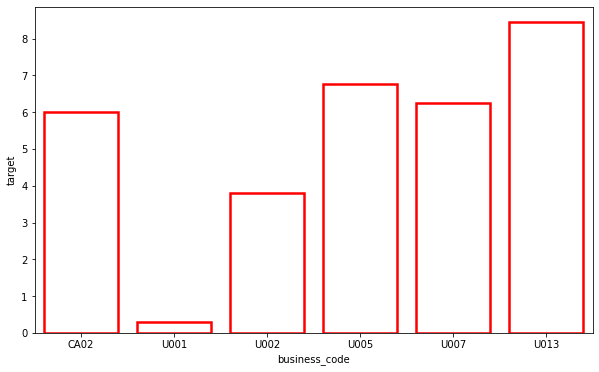

In [47]:
temp = pd.DataFrame(X_train.groupby(['business_code'], axis=0, as_index=False)['target'].mean())
plt.figure(figsize=(10,6))
sns.barplot(x="business_code", y="target",data=temp,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".4", edgecolor="red")

In [48]:
x_pos = np.arange(4)

In [49]:
x_pos

array([0, 1, 2, 3])

In [50]:
# Encoding the binary categorical column invoice_currency
X_train['invoice_currency'] = X_train['invoice_currency'].map({'USD': 0,'CAD': 1})
X_test['invoice_currency'] = X_test['invoice_currency'].map({'USD': 0,'CAD': 1})

<AxesSubplot:xlabel='invoice_currency', ylabel='target'>

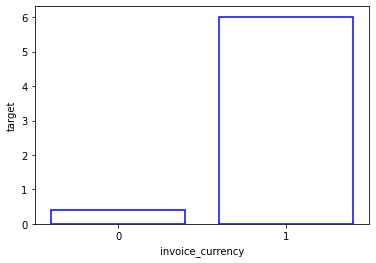

In [51]:
temp1 = pd.DataFrame(X_train.groupby(['invoice_currency'], axis=0, as_index=False)['target'].mean())
plt.figure(figsize=(6,4))
sns.barplot(x="invoice_currency", y="target",data=temp1,linewidth=1.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor="blue")

e:\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_open_amount', ylabel='Density'>

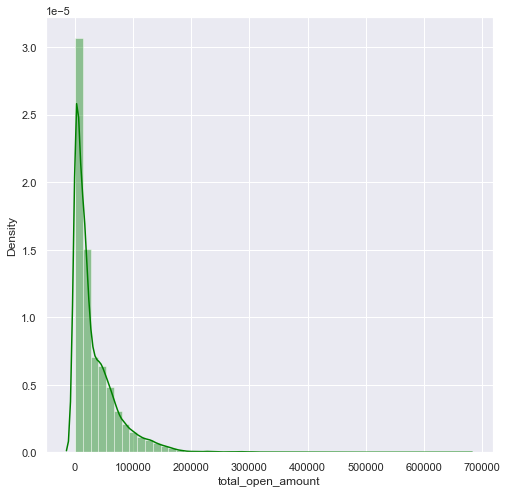

In [52]:
sns.set(style="darkgrid")
plt.figure(figsize=(8,8))
plt.figure(1)
sns.distplot(X_train['total_open_amount'],color='green')

In [53]:
# Using log transformation to make it more 'normal' for better analysis
def Transform(x):
    return np.log(x)

X_train['total_open_amount'] = X_train['total_open_amount'].apply(Transform)
X_test['total_open_amount'] = X_test['total_open_amount'].apply(Transform)

In [54]:
X_train['cust_number'].nunique()

1294

In [55]:
# This pretty much doesnt give much info as its unique for each row
X_train['invoice_id'].nunique()

34228

In [56]:
# Dropping those columns which don't contribute anything for predictions.
X_train = X_train.drop(['buisness_year', 'due_in_date', 'isOpen'], axis = 1)
X_test = X_test.drop(['buisness_year', 'due_in_date', 'isOpen'], axis = 1)

e:\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target', ylabel='Density'>

<Figure size 432x432 with 0 Axes>

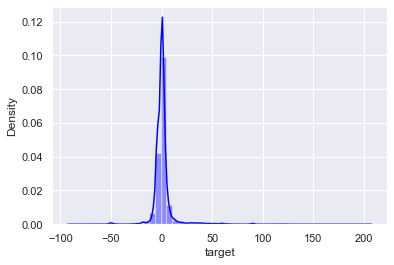

In [57]:
plt.figure(figsize=(6,6))
plt.figure(2)
sns.distplot(X_train['target'],color='blue')

In [58]:
print(dict(X_train['cust_number'].value_counts()))
def integers(x):
    ref = dict(X_train['cust_number'].value_counts())
    if ref.get(x):
        return ref[x]

X_train['cust_number'] = X_train['cust_number'].apply(integers)

{'0200769623': 7763, '0200726979': 1285, '0200762301': 1028, '0200759878': 908, '0200794332': 767, '0200744019': 690, '0200772670': 639, '200769623': 623, '0200705742': 584, '0200707822': 490, 'CCU013': 463, 'CCCA02': 377, '0140106408': 359, '0140104409': 354, '0200418007': 352, '0200780383': 336, '0200803720': 309, '0140104429': 302, '0200706844': 284, '0200761734': 281, '0200230690': 263, '0100031704': 263, '0200936373': 262, '0200793568': 260, '0200799367': 258, '0200353024': 250, '0200416837': 248, '0140105686': 240, '0200148860': 236, '0200704858': 219, '0200020431': 211, '0200974851': 208, '0140104440': 207, '0200772595': 204, '0200782001': 188, '0200729942': 175, '0200714710': 165, '0200592182': 161, '0200739534': 151, '0200900909': 146, '0200764795': 144, '0140105847': 141, '0200704045': 134, '0200792734': 132, '0200763814': 132, '0200752302': 125, '0140104423': 120, '0200777735': 117, '0200781803': 117, '0200718130': 116, '0200331749': 112, '0200707005': 108, '0200705372': 108

In [59]:
def integers_test(x):
    ref = dict(X_test['cust_number'].value_counts())
    if ref.get(x):
        return ref[x]
    
X_test['cust_number'] = X_test['cust_number'].apply(integers_test)

In [60]:
X_train.head(3)

,business_code,cust_number,name_customer,clear_date,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,due_date,target
1,U001,50,BEN E,2019-08-08,1.929646e+09,2019-07-22,2019-07-22,0,11.285480,2019-07-22,NAD1,1.929646e+09,2019-08-11,-3
2,U001,132,MDV/ trust,2019-12-30,1.929874e+09,2019-09-14,2019-09-14,0,7.720400,2019-09-14,NAA8,1.929874e+09,2019-09-29,92
4,U001,7763,WAL-MAR foundation,2019-11-25,1.930148e+09,2019-11-13,2019-11-13,0,10.408294,2019-11-13,NAH4,1.930148e+09,2019-11-28,-3


In [61]:

X_train = X_train.replace(['U002', 'U005', 'U007'], 'other')
X_test = X_test.replace(['U002', 'U005', 'U007'], 'other')

business = pd.get_dummies(X_train['business_code'])
business1 = pd.get_dummies(X_test['business_code'])
# Above in the business_code column we can see they are categorical ones, so we make new feature
# out of them 
X_train = pd.concat([X_train, business], axis=1)
X_test = pd.concat([X_test, business1], axis=1)

X_train.head()

,business_code,cust_number,name_customer,clear_date,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,due_date,target,CA02,U001,U013,other
1,U001,50,BEN E,2019-08-08,1.929646e+09,2019-07-22,2019-07-22,0,11.285480,2019-07-22,NAD1,1.929646e+09,2019-08-11,-3,0,1,0,0
2,U001,132,MDV/ trust,2019-12-30,1.929874e+09,2019-09-14,2019-09-14,0,7.720400,2019-09-14,NAA8,1.929874e+09,2019-09-29,92,0,1,0,0
4,U001,7763,WAL-MAR foundation,2019-11-25,1.930148e+09,2019-11-13,2019-11-13,0,10.408294,2019-11-13,NAH4,1.930148e+09,2019-11-28,-3,0,1,0,0
5,CA02,77,THE corporation,2019-12-04,2.960581e+09,2019-09-20,2019-09-20,1,10.009011,2019-09-24,CA10,2.960581e+09,2019-10-04,61,1,0,0,0
6,U001,7763,WAL-MAR in,2019-11-12,1.930083e+09,2019-11-01,2019-10-31,0,8.903610,2019-11-01,NAH4,1.930083e+09,2019-11-16,-4,0,1,0,0


In [62]:
# creating a new feature from baseline column.
X_train['baseline_quater']= pd.to_datetime(X_train['baseline_create_date']).dt.quarter
X_test['baseline_quater']= pd.to_datetime(X_test['baseline_create_date']).dt.quarter


In [63]:
X_train = X_train.replace(['NAA8', 'NAAX', 'NAAW'], 'NAA')
X_train = X_train.replace(['NAGD', 'NAUZ', 'NAVF', 'NAVE', 'NAVR', 'NAWN', 'NAVQ',
                                  'NAWP', 'NAVM', 'NACB', 'NABG','NAVD', 'NAVL', 'NAUP', 'NATJ', 'NATH', 
                                  'NATU', 'NA8Q', 'NAVC', 'NANC', 'NATK', 'NAUI', 'NAWM',
                                  'NATL', 'NAUY', 'NATW', 'NATX', 'NAWU'], 'NA_place')

X_train = X_train.replace(['NAH4', 'NAC6', 'NAM4', 'NAD1', 'NAU5', 'NAG2', 'NAX2', 'NAD5', 'NAM1',
                                  'NAD4','NAB1','NAM2','NAM3', 'NAV9',  'NAV2', 'NAD8'], 'NA_letter_number')

X_train = X_train.replace(['NA3B', 'NA3F', 'NA9X'], 'NA_number_letter')

X_train = X_train.replace(['NA32', 'NA10', 'NA38', 'NA84', 'NA25', 'NA31'], 'NA_number_number')

X_train = X_train.replace(['CA10', 'CA30', 'C106', 'CAX2', 'CAB1', 'C129', 'CA60'], 'CA')

X_train = X_train.replace(['C106', 'C129', '90M7'], 'C_number')

X_train = X_train.replace(['BR56', 'B030', 'B052', 'BR12', 'B112'], 'B')

X_train['cust_payment_terms'].value_counts()

NAA                 15006
NA_letter_number    14718
CA                   2791
NA_place             1498
NA_number_number      877
NA_number_letter       54
B                      14
NATM                    7
C_number                2
NATV                    1
NAUW                    1
NABD                    1
MC15                    1
Name: cust_payment_terms, dtype: int64

In [64]:
X_test = X_test.replace(['NAA8', 'NAAX', 'NAAW'], 'NAA')

X_test = X_test.replace(['NAGD', 'NAUZ', 'NAVF', 'NAVE', 'NAVR', 'NAWN', 'NAVQ',
                                  'NAWP', 'NAVM', 'NACB', 'NABG','NAVD', 'NAVL', 'NAUP', 'NATJ', 'NATH', 
                                  'NATU', 'NA8Q', 'NAVC', 'NANC', 'NATK', 'NAUI', 'NAWM',
                                  'NATL', 'NAUY', 'NATZ', 'NACE', 'NATZ'], 'NA_place')

X_test = X_test.replace(['NAH4', 'NAC6', 'NAM4', 'NAD1', 'NAU5', 'NAG2', 'NAX2', 'NAD5', 'NAM1',
                                  'NAD4','NAB1','NAM2','NAM3', 'NAV9',  'NAV2', 'NAD8'], 'NA_letter_number')

X_test = X_test.replace(['NA3B', 'NA3F', 'NA9X'], 'NA_number_letter')

X_test = X_test.replace(['NA32', 'NA10', 'NA38', 'NA84', 'NA25', 'NA31'], 'NA_number_number')

X_test = X_test.replace(['CA10', 'CA30', 'C106', 'CAX2', 'CAB1', 'C129', 'CA60'], 'CA')

X_test = X_test.replace(['C106', 'C129', '90M7'], 'C_number')

X_test = X_test.replace(['BR56', 'B030', 'B052'], 'B')

X_test['cust_payment_terms'].value_counts()

NA_letter_number    2147
NAA                 2131
CA                   349
NA_place             238
NA_number_number     146
NA_number_letter       8
C_number               3
BR12                   1
Name: cust_payment_terms, dtype: int64

In [65]:
# See however a discrepency has occurred i.e. there is no column of B
# so we just add a column B with values 0.
X_test['B'] = np.zeros(5023)
X_test.head(3)

,business_code,cust_number,name_customer,clear_date,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,due_date,target,CA02,U001,U013,other,baseline_quater,B
0,U001,1179,WAL-MAR corp,2020-02-11,1.930438e+09,2020-01-26,2020-01-25,0,10.901787,2020-01-26,NA_letter_number,1.930438e+09,2020-02-10,1,0,1,0,0,1,0.0
19,U001,1179,WAL-MAR systems,2020-02-05,1.930438e+09,2020-01-24,2020-01-24,0,10.884621,2020-01-24,NA_letter_number,1.930438e+09,2020-02-08,-3,0,1,0,0,1,0.0
20,U013,3,SYSTEMS systems,2020-02-11,1.991838e+09,2020-01-11,2020-01-07,0,8.645323,2020-01-11,NA_place,1.991838e+09,2020-02-10,1,0,0,1,0,1,0.0


In [66]:
payment = pd.get_dummies(X_train['cust_payment_terms'])
payment1 = pd.get_dummies(X_test['cust_payment_terms'])

# Above in the cust_payment_terms column we can see they are categorical ones, so we make new feature
# out of them 
X_final = pd.concat([X_train, payment], axis=1)
X_final_test = pd.concat([X_test, payment1], axis=1)

X_final.head(1)

,business_code,cust_number,name_customer,clear_date,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,baseline_create_date,...,MC15,NAA,NABD,NATM,NATV,NAUW,NA_letter_number,NA_number_letter,NA_number_number,NA_place
1,U001,50,BEN E,2019-08-08,1.929646e+09,2019-07-22,2019-07-22,0,11.28548,2019-07-22,...,0,0,0,0,0,0,1,0,0,0


In [67]:
X_final.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date', 'doc_id',
       'posting_date', 'document_create_date', 'invoice_currency',
       'total_open_amount', 'baseline_create_date', 'cust_payment_terms',
       'invoice_id', 'due_date', 'target', 'CA02', 'U001', 'U013', 'other',
       'baseline_quater', 'B', 'CA', 'C_number', 'MC15', 'NAA', 'NABD', 'NATM',
       'NATV', 'NAUW', 'NA_letter_number', 'NA_number_letter',
       'NA_number_number', 'NA_place'],
      dtype='object')

<AxesSubplot:>

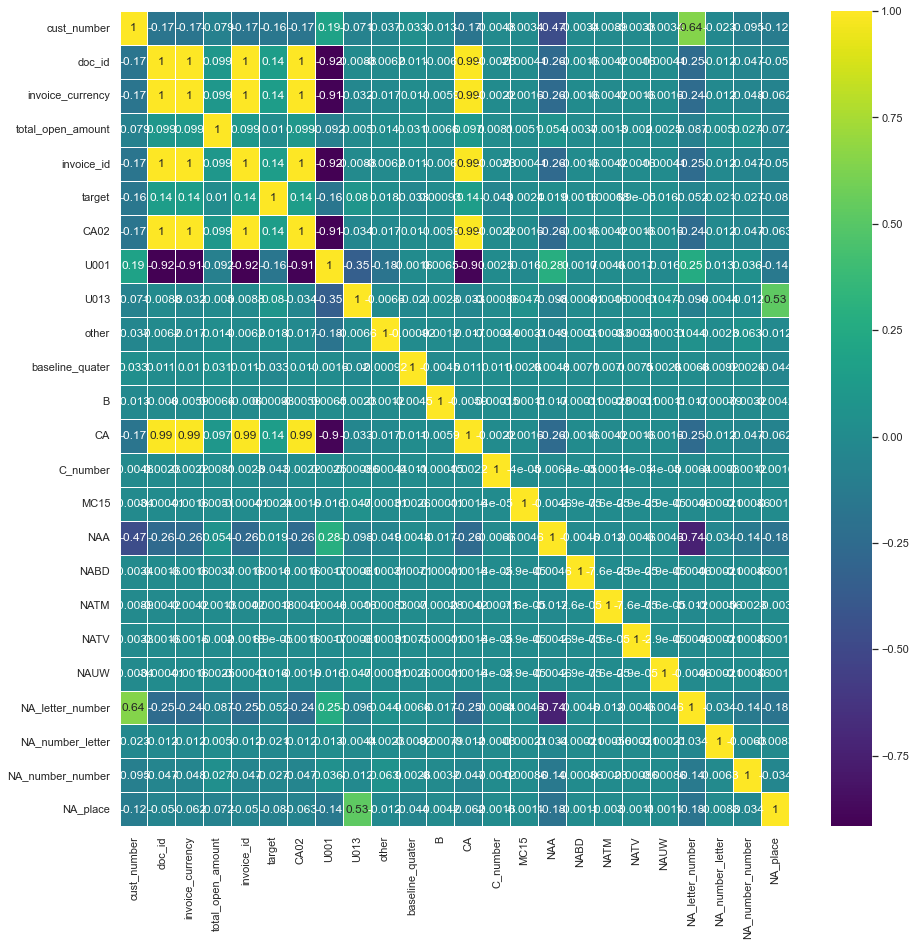

In [68]:
# X_final.columns
plt.figure(figsize=(15,15))
sns.heatmap(X_final.corr(),annot=True,cmap='viridis',linewidths=.5)

In [69]:
# dropping columns that won't help in predictions. Note on feature has high correlation with target variable.
X_final = X_final.drop(['doc_id', 'invoice_id','business_code', 'name_customer', 'clear_date',
                       'posting_date', 'document_create_date', 'baseline_create_date', 'cust_payment_terms',
                       'invoice_id', 'due_date'], axis = 1)

X_final_test = X_final_test.drop(['doc_id', 'invoice_id','business_code', 'name_customer', 'clear_date',
                       'posting_date', 'document_create_date', 'baseline_create_date', 'cust_payment_terms',
                       'invoice_id', 'due_date'], axis = 1)

In [70]:
X_final.head(1)

,cust_number,invoice_currency,total_open_amount,target,CA02,U001,U013,other,baseline_quater,B,...,MC15,NAA,NABD,NATM,NATV,NAUW,NA_letter_number,NA_number_letter,NA_number_number,NA_place
1,50,0,11.28548,-3,0,1,0,0,3,0,...,0,0,0,0,0,0,1,0,0,0


# Training and Splitting 

In [63]:
y = X_final['target']
X_final = X_final.drop(['target'], axis = 1)
Xtrain ,Xtest, ytrain, ytest = train_test_split(X_final, y, test_size = 0.2, random_state=0)

In [64]:
l = list(np.isfinite(ytrain))
print([x for x in l if x == False])

[]


In [65]:
lp = list(np.isfinite(Xtrain))
print([x for x in lp if x == False])

[]


In [66]:
random_model = RandomForestRegressor(n_estimators=500)

In [67]:
#Fit
random_model.fit(Xtrain, ytrain)

y_pred3 = random_model.predict(Xtest)

#Checking the accuracy
random_model_accuracy = round(random_model.score(Xtrain, ytrain)*100,2)
print(round(random_model_accuracy,2),'%')

89.9 %


In [68]:
#X_final_test.isna().sum()
#X_final_test = X_final_test['cust_number'].fillna(value=0)
X_final_test.columns

Index(['cust_number', 'invoice_currency', 'total_open_amount', 'target',
       'CA02', 'U001', 'U013', 'other', 'baseline_quater', 'B', 'BR12', 'CA',
       'C_number', 'NAA', 'NA_letter_number', 'NA_number_letter',
       'NA_number_number', 'NA_place'],
      dtype='object')

In [69]:
real_time_data = random_model.predict(X_final_test)
real_time_data[0:3]

e:\conda\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- BR12
- target
Feature names seen at fit time, yet now missing:
- MC15
- NABD
- NATM
- NATV
- NAUW

  warnings.warn(message, FutureWarning)


ValueError: X has 18 features, but RandomForestRegressor is expecting 21 features as input.

In [ ]:
def Mapping(x):
    temp = []
    for i in list(x):
        if i < 0:
            temp.append("Payment done before due date.")
        elif i > 15:
            temp.append("Payment done 15 days after due date.")
        elif i > 30:
            temp.append("Payment done 30 days after due date.")
        else:
            temp.append("Payment done much after due date.")
    return temp

col2 = Mapping(real_time_data)
bucket = pd.DataFrame()
bucket['Predictions'] = real_time_data
bucket['Bucket_list'] = col2
bucket.head()